In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from IPython.display import clear_output

from io import BytesIO, StringIO
import os
import boto3

import nltk
import demoji
import google_play_scraper
from google_play_scraper import app
from app_store_scraper import AppStore
from pprint import pprint
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from os import listdir
from os.path import isfile, join
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import pickle

# nltk.download("stopwords")
with open('/home/jovyan/nltk_data/corpora/stopwords/russian', 'r') as file:
    stopwords = [line.rstrip() for line in file]
warnings.filterwarnings("ignore")

clear_output()

### prepare unlabeled data

In [56]:
vit_apple_unlabeled = pd.read_csv('data/apple/2024-01/ViT.csv')
vit_google_unlabeled = pd.read_csv('data/google/2024-01/ViT.csv')

### clean data

In [53]:
cutoff_date = '2024-01-01'

In [57]:
vit_google_unlabeled = (
    vit_google_unlabeled
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            vit_google_unlabeled['at'], 
            format="%Y-%m-%d %H:%M:%S")
    )
    .rename(
        columns={'content':'review',
                'score':'rating'}
    )
    .loc[
        # use date for 2024-01 only
        (vit_google_unlabeled['at'] >= cutoff_date),
        # use these cols only
        ['review', 'date', 'rating']
    ]
    .reset_index(drop=True)
)
vit_google_unlabeled.head(1)

In [60]:
vit_apple_unlabeled = (
    vit_apple_unlabeled
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            vit_apple_unlabeled.date, 
            format="%Y-%m-%d %H:%M:%S")
    )
    .loc[
        # use date for 2024-01 only
        (vit_apple_unlabeled.date >= cutoff_date),
        # use these cols only
        ["date", "review", "rating", "title"]
    ]
    .reset_index(drop=True)
)
vit_apple_unlabeled.head(1)

In [122]:
reviews_unlabeled = pd.concat([vit_apple_unlabeled, vit_google_unlabeled])

In [233]:
type_to_num_dict = {"Функционал приложения": 0,
                    "QR-код/Отзывы": 1,
                    "Акции/Цены": 2,
                    "Ассортимент/Качество еды": 3,
                    "Возврат денег/Отмена заказа": 4,
                    "Доставка": 5,
                    "Интерфейс приложения": 6,
                    "Локация ПБО": 7,
                    "Обслуживание ПБО": 8,
                    "Оплата": 9,
                    "Неинформативно": 10,
                    "Ошибка приложения": 11,
                    "Регистрация в приложении": 12}

num_to_type_dict = {v: k for k, v in type_to_num_dict.items()}

In [70]:
reviews_labeled = (
    reviews_labeled
    .copy()
    .assign(
        # convert date to datetime format
        date=pd.to_datetime(
            reviews_labeled["Review Last Update Date and Time"], 
            format="%d.%m.%Y %H:%M")
    )
    .rename(columns={"Review Text": "review",
                     "Star Rating": "rating",
                     "Review Title": "title",
                     "type of review": "review_type"}
    )
    .loc[
        # only labeled reviews
        (reviews_labeled["type of review"].notna()),
        # use these cols only
        ["date", "review", "rating", "title", "review_type"]
    ]
    .reset_index(drop=True)
)

reviews_labeled['rev_type_num'] = (
    reviews_labeled['review_type']
    .replace(type_to_num_dict)
    .values
)

reviews_labeled.head(1)

,date,review,rating,title,review_type
0,2023-07-01 07:32:00,Может пора уже прислушаться к пользователям и ...,2,NaN,Неинформативно


In [75]:
reviews_labeled[["review", "review_type"]].groupby(["review_type"]).count().sort_values('review')

,review
review_type,
Интерфейс приложения,11
QR-код/Отзывы,14
Регистрация в приложении,14
Ассортимент/Качество еды,15
Оплата,16
Акции/Цены,18
Ошибка приложения,23
Обслуживание ПБО,25
Локация ПБО,30


### preprocess text

In [116]:
def generate_stopwords():
    """
    base nltk stopwords + custom stopwords
    """
    russian_stopwords = stopwords
    # custom_stopwords = ['точка']
    all_stopwords = russian_stopwords #+ custom_stopwords
    return all_stopwords


def preprocess_text(text, all_stopwords, stemmer):
    """
    lemmatize, lower, stopwords, punctuation, drop emoji
    """
    # remove emoji
    text = remove_emoji(text)
    
    # split text into separate words
    text = word_tokenize(text)
    tokens = list()
    
    for word in text:
        # stemming - cut off the ending of a word
        stemmed_word = stemmer.stem(word.lower())
        tokens.append(stemmed_word)
        
    # remove stopwords and punctuation
    tokens = [token for token in tokens if token not in all_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    # get text with stemmed words and 
    # without stopwords and punctuation
    text = " ".join(tokens)
    return text


def preprocess_rev(_df):
    """
    add column with preprocessed text
    """
    stemmer = SnowballStemmer(language="russian") 
    all_stopwords = generate_stopwords()
    _df['review_processed'] = _df.apply(lambda x: preprocess_text(x.review, all_stopwords, stemmer), axis=1)
    return _df

def remove_emoji(text):
    """
    remove emoji from any text
    """
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    
    return text

In [131]:
preprocessed_reviews_labeled = preprocess_rev(reviews_labeled)
preprocessed_reviews_labeled.head(2)

,date,review,rating,title,review_type,review_processed,rev_type_num
0,2023-07-01 07:32:00,Может пора уже прислушаться к пользователям и ...,2,NaN,Неинформативно,пор прислуша пользовател доработа приложен смы...,10
1,2023-07-01 10:04:00,Хачууу ЕСТЬ😊,1,NaN,Неинформативно,хачуу ест,10


In [304]:
preprocessed_reviews_labeled[
        preprocessed_reviews_labeled.rating > 3
    ].shape

(0, 7)

In [298]:
(
    preprocessed_reviews_labeled[
        preprocessed_reviews_labeled.apply(lambda x: len(x['review_processed'].split(' ')), axis=1) < 5
    ]
    .groupby('review_type')
    .count()
)

,date,review,rating,title,review_processed,rev_type_num
review_type,,,,,,
QR-код/Отзывы,2,2,2,0,2,2
Акции/Цены,1,1,1,0,1,1
Ассортимент/Качество еды,5,5,5,0,5,5
Доставка,5,5,5,0,5,5
Интерфейс приложения,1,1,1,0,1,1
Локация ПБО,1,1,1,0,1,1
Неинформативно,43,43,43,0,43,43
Обслуживание ПБО,3,3,3,0,3,3
Оплата,2,2,2,0,2,2


In [305]:
# preprocessed_reviews_unlabeled = preprocess_rev(reviews_unlabeled)

# rating <=3 and more that 4 preprocessed words
preprocessed_reviews_unlabeled = (
    preprocessed_reviews_unlabeled[
        (preprocessed_reviews_unlabeled.rating <= 3)
        &(preprocessed_reviews_unlabeled.apply(lambda x: len(x['review_processed'].split(' ')), axis=1) >= 5)
    ]
)

preprocessed_reviews_unlabeled.head(2)

,date,review,rating,title,review_processed
0,2024-01-16 18:40:08,"Не обновляет страницу заказов, пишет, что нет ...",1,Статус заказа,обновля страниц заказ пишет соединен никак отс...
1,2024-01-16 07:27:57,Единица за то что не смогла сделать заказ чере...,1,Не смогла сделать заказ,единиц смогл сдела заказ приложен ввож адрес н...


### Tfidf and model

In [138]:
from sklearn.model_selection import (
    train_test_split,
    # HalvingRandomSearchCV
)

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [307]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_reviews_labeled.review_processed, 
    preprocessed_reviews_labeled.rev_type_num, 
    random_state=18, 
    test_size=0.3, 
    stratify=preprocessed_reviews_labeled.rev_type_num
)

In [308]:
vectorizer = TfidfVectorizer(min_df=10)
x = vectorizer.fit_transform(X_train.values)

In [309]:
x_t = vectorizer.transform(X_test.values)

In [189]:
vectorizer.inverse_transform(x[0])

[array(['ваш', 'заказыва', 'приход', 'есл', 'приложен', 'списа', 'деньг',
        'минут', 'сдела', 'ест', 'заказ'], dtype='<U12')]

In [199]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score, roc_auc_score,
    classification_report, make_scorer
)

In [310]:
model = RandomForestClassifier() 

In [311]:
model.fit(x, y_train)

RandomForestClassifier()

In [312]:
f1_score(y_test, model.predict(x_t), average='weighted')

0.4071351143385042

<Axes: ylabel='index'>

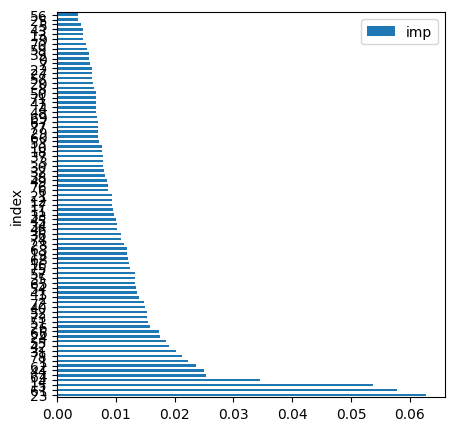

In [218]:
(
    pd.DataFrame({'imp' : model.feature_importances_})
    .reset_index()
    .sort_values('imp', ascending=False)
 .plot.barh(y='imp', x='index', figsize=(5,5))
)


In [313]:
X_unlabeled = (
    vectorizer
    .transform(preprocessed_reviews_unlabeled.review_processed)
)

In [314]:
predicted = (
    preprocessed_reviews_unlabeled
    .copy()
    .assign(
        preds = model.predict(X_unlabeled)
    )
    .assign(
        type_preds = (
            pd.DataFrame(model.predict(X_unlabeled))
            .replace(num_to_type_dict)
            .values
            .reshape(-1)
        )
    )
)

In [325]:
predicted[predicted["type_preds"] == "Локация ПБО"].review.tolist()[:6]

['Категорически не хотят осуществлять доставку в наш район.',
 'Видишь условно цены в меню одни, кликаешь на комбо, цена уже совсем другая, так ещё и доставка от 208 до 300 рублей, автоматом в баню!',
 'Ввожу адрес доставки, нажимаю кнопку «готово», она становится не активной. И всё. Ничего не происходит.',
 'Не могу выбрать адрес доставки! Точка рядом а доставка по адресу не доступна…\nЭто как понимать вообще?',
 'Адрес доставки неизвестно откуда взялся и невозможно изменить, чтт за идиотизм?',
 'Доставка есть только в рекламе. По факту же любой адрес в Москве, цитирую: «доставка по данному адресу временно не доступна».']

In [277]:
num_to_type_dict

{0: 'Функционал приложения',
 1: 'QR-код/Отзывы',
 2: 'Акции/Цены',
 3: 'Ассортимент/Качество еды',
 4: 'Возврат денег/Отмена заказа',
 5: 'Доставка',
 6: 'Интерфейс приложения',
 7: 'Локация ПБО',
 8: 'Обслуживание ПБО',
 9: 'Оплата',
 10: 'Неинформативно',
 11: 'Ошибка приложения',
 12: 'Регистрация в приложении'}

In [328]:
pd.read_csv('./data/google/Аналитика отзывов.csv', sep=';')


,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,type of rewiev,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link
0,com.apegroup.mcdonaldsrussia,12415.0,10.2.0,ru,surya,01.07.2023 5:15,"1,68818E+12",01.07.2023 5:15,"1,68818E+12",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,com.apegroup.mcdonaldsrussia,NaN,NaN,ru,a51,01.07.2023 6:06,"1,68818E+12",01.07.2023 6:06,"1,68818E+12",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,com.apegroup.mcdonaldsrussia,12415.0,10.2.0,ru,vili,01.07.2023 7:32,"1,68819E+12",01.07.2023 7:32,"1,68819E+12",2,NaN,Может пора уже прислушаться к пользователям и ...,Функционал приложения,06.07.2023 18:51,"1,68866E+12",Если есть предложения по разработке приложения...,http://play.google.com/console/developers/8647...
3,com.apegroup.mcdonaldsrussia,NaN,NaN,ru,RE588BL1,01.07.2023 8:17,"1,68819E+12",01.07.2023 8:17,"1,68819E+12",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,com.apegroup.mcdonaldsrussia,NaN,NaN,ru,RE5887,01.07.2023 8:41,"1,68819E+12",01.07.2023 8:41,"1,68819E+12",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,com.apegroup.mcdonaldsrussia,12769.0,10.3.1,ru,r8q,26.07.2023 8:34,"1,69035E+12",26.07.2023 8:34,"1,69035E+12",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2335,com.apegroup.mcdonaldsrussia,12769.0,10.3.1,ru,OP533FL1,26.07.2023 8:44,"1,69035E+12",26.07.2023 8:44,"1,69035E+12",1,NaN,Почините функцию выбора предприятия!!!! Зачем ...,Функционал приложения,NaN,NaN,NaN,http://play.google.com/console/developers/8647...
2336,com.apegroup.mcdonaldsrussia,12769.0,10.3.1,ru,m32,26.07.2023 9:01,"1,69035E+12",26.07.2023 9:01,"1,69035E+12",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2337,com.apegroup.mcdonaldsrussia,12769.0,10.3.1,ru,r8q,26.07.2023 9:44,"1,69035E+12",26.07.2023 9:44,"1,69035E+12",1,NaN,Название поменялось и качество обслуживание то...,Обслуживание ПБО,NaN,NaN,NaN,http://play.google.com/console/developers/8647...


### r